<div>
      <img src="https://drive.google.com/uc?export=view&id=1XqMCyXys9E6QBvNAW8QSTAdT0dkB8aAa" width="40%" align="right"/>
</div>

<div>
        <br><h4>Daniel Brauner, Felix Scharf, Herbi Shtini</h4>
</div>

# Modeling

Im Rahmen der Modellierung oder Modeling werden die für die Aufgabenstellung geeigneten Methoden des Data Minings auf den in der Datenvorbereitung erstellten Datensatz angewandt. Weiterhin werden in dieser Phase Optimierungen der Parameter vorgenommen.

Im ersten Schritt werden die benötigten Bibliotheken installiert.
Wir verwenden numpy, pandas, seaborn und matplotlib.

NumPy und Pandas sind Programmbibliotheken für die Programmiersprache Python, die die Handhabung großer mehrdimensionaler Arrays ermöglichen. 

Matplotlib und Seaborn sind ebenfalls Programmbibliotheken für Python, welche  Visualisierungen und Darstellungen ermöglichen.

In dieser Phase wird zudem auf die Programmbibliothek scikit-learn zurückgegriffen.

Mithilfe von Scikit-learn erfolgt die Modellierung der Daten. 

Es werden Methoden und Lernmodelle für maschinelles Lernen erzeugt und angewandt.

Typische Anwendungsbereiche von scikit-learn sind hierbei Clustering, Cross Validation und Parameter-Tuning.



##### Importe

In [1]:
import numpy as np
import pandas as pd
import time
# Plots
import seaborn as sns
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
#import plotly.graph_objs as go

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer

##### Hilfsfunktionen

In [2]:
def toPercent(nr):
  return format(nr * 100, '.2f')+'%'

def plotAccuracyAndError(paramArray, train_scores, test_scores, rmse_list, mae_list):  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
  ax1.plot(paramArray, train_scores, '-o', label='Train')
  ax1.plot(paramArray, test_scores, '-o', label='Test')
  ax1.legend()

  ax2.plot(paramArray, rmse_list, '-o', color='purple', label='RMSE')
  ax2.plot(paramArray, mae_list, '-o', color='red', label='MAE')
  ax2.legend()
  plt.show()

def getFilteredImportances(f_importances):
  imp = pd.Series(f_importances, index=FEATURES)
  imp['Stadt'] = imp[imp.index.isin(list(filter(lambda k: 'regio2_' in k, 
                                                imp.index)))].sum()
  imp['Innere Qualität'] = imp[imp.index.isin(list(filter(lambda k: 'interiorQual_' in k, 
                                                          imp.index)))].sum()

  imp = imp[~imp.index.isin(list(filter(lambda k: 'regio2_' in k, imp.index)))]
  imp = imp[~imp.index.isin(list(filter(lambda k: 'interiorQual_' in k, imp.index)))]
  sorted_importances = imp.sort_values(ascending=False)
  sorted_importances = sorted_importances[0:10]
  return sorted_importances
  
def plotFeatureImportance(importances):
  dt_importances = pd.Series(importances)

  fig, ax = plt.subplots(figsize=(15,5))
  dt_importances.plot.bar(ax=ax)
  ax.set_title("Feature importances")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()

# rent per city
def getCities():
  cityColumns = filter(lambda column: 'regio2_' in column, FEATURES)
  cityColumns = list(cityColumns)
  cities = []
  for city in cityColumns:
    cities.append(city.split('regio2_')[1])
  return cities

def generateXYData(model, pred_data):
  rent_list = []
  cities = getCities()
  counts = []
  for city in cities:
    cityColumn = 'regio2_'+city
    ap = pred_data.copy()
    ap.iloc[0][cityColumn] = 1
    pred = gbr_model.predict(ap)[0]
    rent_list.append(int(pred))
    counts.append(len(df[df[cityColumn] == 1]))
  return pd.DataFrame({'cityIndex': range(1, len(cities)+1, 1), 
                       'city': cities, 'rent': rent_list, 'offers': counts})

def plotCityPrice(dfs=[], titles=[], barColors=[]):
  # Scatterplot
  fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(19, 12))
  row1 = pd.Series([ax1, ax2, ax3])
  row2 = pd.Series([ax4, ax5, ax6])
  for i, ax in row1.iteritems():
    sns.scatterplot(data=dfs[i], 
                x='cityIndex', y='rent', size='offers', 
                alpha=.7, sizes=(50, 400), ax=row1[i])
    row1[i].set_title(titles[i])
    row1[i].set_xlabel('Stadt')
    row1[i].set_ylabel('Warmmiete')
    row1[i].legend(loc='upper left')
    row1[i].yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, 
                                                        p: '{:.0f} €'.format(x)))
    row1[i].set(xticklabels=[])
    # Set labels
    label_point(dfs[i].cityIndex, dfs[i].rent, dfs[i].city, row1[i]) 

  # Bar chart
  for i, ax in row2.iteritems():
    sns.barplot(data=dfs[i], x="city", y="rent", color=barColors[i], ax=row2[i])
    #row2[i].set_title(titles[i])
    row2[i].set_xlabel('Stadt')
    row2[i].set_ylabel('Warmmiete')
    row2[i].axhline(dfs[i].rent.mean(), color='r')
    row2[i].set_ylim(0, 1800)
    row2[i].set_xticklabels(row2[i].get_xticklabels(), 
                            rotation=45, horizontalalignment='right')
    row2[i].yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, 
                                                        p: '{:.0f} €'.format(x)))
    label_bar(dfs[i].city, dfs[i].rent, dfs[i].rent, row2[i])

# Barplot top label
def label_bar_percent(x, y, val, ax):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    if i > 0:
      curr = a['y'][i]
      prev = a['y'][i - 1]
      perc = (curr - prev) * 100/prev
      format = '{:.1f} %'.format(perc) if (perc < 0) else '+{:.1f} %'.format(perc)
      ax.text(i, point['y']*0.5, format, color='black', ha="center")

def label_catplot_percent(ax, cities, dates):
  for date in dates:
    dateI = dates.index(date)
    for city in cities:
      cityI = cities.index(city)
      currI = (dateI*len(cities) + cityI)
      prevI = (currI - len(cities))
      if dateI > 0:
        x = ax.patches[currI].get_x()
        y = ax.patches[currI].get_height()
        curr = ax.patches[currI].get_height()
        prev = ax.patches[prevI].get_height()
        perc = (curr - prev) * 100/prev
        format = '{:.1f} %'.format(perc) if (perc < 0) else '+{:.1f} %'.format(perc)
        ax.text(x, y, format, color='black', rotation='horizontal', size='small')

def label_point(x, y, val, ax):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x']+0.2, point['y']-5, str(point['val']))

def label_bar(x, y, val, ax):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(i, point['y'], '{:.0f} €'.format(point['val']), 
            color='black', ha="center")

# Generating prediction input 
def getApartmentDf(livingSpace=55, newlyConst=0, balcony=1, 
                   yearConstructed=1960, noRooms = 2, 
                   hasKitchen=1, normal=1, luxury=0, cellar=1, 
                   berlin=0, lift=0, garden=0, floor=1):  
  ap = pd.DataFrame(columns=FEATURES)
  ap = ap.append({'livingSpace': livingSpace,
                                'regio2_Berlin': berlin,
                                'interiorQual_normal': normal,
                                'interiorQual_luxury': luxury,
                                'typeOfFlat_apartment': 1,
                                'heatingType_central_heating': 1,
                                'yearConstructed': yearConstructed,
                                'hasKitchen': hasKitchen,
                                'floor': floor,
                                'lift': lift,
                                'noRooms': noRooms,
                                'cellar': cellar,
                                'newlyConst': newlyConst,
                                'garden': garden,
                                'balcony': balcony}, ignore_index=True)
  ap = ap.fillna(0)
  return ap.copy()

def addOverviewPlot(title, ax, y_pred):
  sns.scatterplot(y_test, y_pred, ax=ax)
  ax.set_title(title)
  ax.set_xlabel('Warmmiete')
  ax.set_ylabel('Vorausgesagte Warmmiete')
  ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} €'.format(x)))
  ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} €'.format(x)))
  z = np.polyfit(y_test, y_pred, 1)
  p = np.poly1d(z)
  ax.plot(y_test,p(y_test), color='red')

In [3]:
sns.set_theme(style='darkgrid')

##### Numerische Daten einlesen

In [4]:
df = pd.read_pickle('data/immo_data_numerical.pkl')

In [5]:
df = df.drop(['serviceCharge', 'baseRent'], axis=1)
df.reset_index()

,index,newlyConst,balcony,totalRent,yearConstructed,hasKitchen,cellar,livingSpace,lift,noRooms,...,regio2_Berlin,regio2_Frankfurt_am_Main,regio2_Hamburg,regio2_Köln,regio2_München,regio2_Stuttgart,date_Feb20,date_May19,date_Oct19,date_Sep18
0,21,0,0,1412.502694,1975.0,0,0,29.00,0,1.5,...,0,0,0,0,0,1,0,0,1,0
1,23,0,0,2030.000000,1871.0,1,1,81.00,0,2.0,...,0,0,0,0,1,0,0,0,1,0
2,24,0,1,760.000000,1953.0,0,1,55.89,0,3.0,...,0,0,1,0,0,0,0,1,0,0
3,45,0,1,1140.000000,1995.0,1,0,77.00,1,3.0,...,1,0,0,0,0,0,1,0,0,0
4,46,0,0,2599.479747,1900.0,0,0,96.00,0,4.0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17549,268819,0,0,1330.000000,1955.0,1,1,75.00,0,3.0,...,0,1,0,0,0,0,1,0,0,0
17550,268829,0,1,828.770000,1972.0,0,0,72.64,1,3.0,...,1,0,0,0,0,0,0,0,0,1
17551,268839,0,1,1980.000000,1900.0,1,0,65.00,0,2.0,...,0,0,0,0,1,0,0,0,0,1
17552,268840,0,1,1479.640000,2016.0,1,1,89.67,1,3.0,...,0,1,0,0,0,0,0,0,0,1


##### Datenaufteilung

Warmmiete ist unser Zielfeature, das die Grundlage dieser Analyse bildet.  Deshalb muss es aus X weggenommen werden.

In [6]:
TARGET = 'totalRent'
FEATURES = sorted(df.drop(TARGET, axis=1).select_dtypes(include=np.number).columns)

y = df[TARGET] 
X = df[FEATURES]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=42)

print('Train shape', X_train.shape, ' Test shape ', X_test.shape)

Train shape (14043, 31)  Test shape  (3511, 31)


### DecisionTree

In [8]:
params_dist = {
 'max_depth': [6, 10, 14, 18, 22],
 'max_leaf_nodes': [2000, 3000],
 'min_samples_leaf': [5, 10],
 'min_samples_split': [30, 40]
}
dtr = DecisionTreeRegressor()
dt_gscv = GridSearchCV(dtr, params_dist, cv=10, return_train_score=True, n_jobs=-1)

dtr = dt_gscv.fit(X_train, y_train)

tuned_dtr = dt_gscv.best_estimator_
tuned_dtr

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=2000, min_samples_leaf=10,
                      min_samples_split=40)

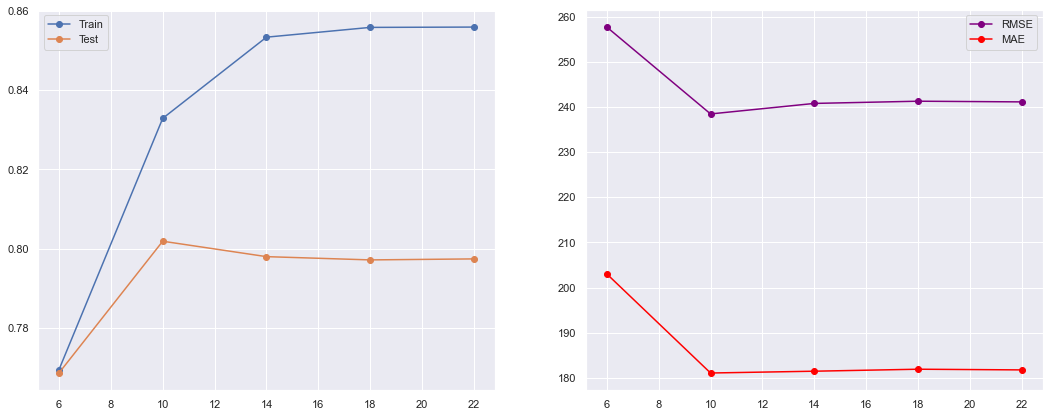

In [9]:
dt_gscv_train = []
dt_gscv_test = []
dt_rmse_list = []
dt_mae_list = []
for depth in params_dist['max_depth']:
  tr = DecisionTreeRegressor(max_depth=depth, max_leaf_nodes=2000, 
                             min_samples_leaf=5, min_samples_split=40)
  preds = tr.fit(X_train, y_train).predict(X_test)
  dt_gscv_train.append(tr.score(X_train, y_train))
  dt_gscv_test.append(tr.score(X_test, y_test))
  dt_rmse_list.append(np.sqrt(mean_squared_error(y_true=y_test, y_pred=preds)))
  dt_mae_list.append(mean_absolute_error(y_true=y_test, y_pred=preds))
  
plotAccuracyAndError(params_dist['max_depth'], dt_gscv_train, dt_gscv_test, 
                     dt_rmse_list, dt_mae_list)

In [10]:
regressor_tunned = DecisionTreeRegressor(
    max_depth=tuned_dtr.max_depth, 
    max_leaf_nodes=tuned_dtr.max_leaf_nodes, 
    min_samples_leaf=tuned_dtr.min_samples_leaf,
    min_samples_split=tuned_dtr.min_samples_split)
regressor_tunned = regressor_tunned.fit(X_train, y_train)
y_pred_dt = regressor_tunned.predict(X_test)

In [11]:
regressor_tunned.get_depth(), regressor_tunned.get_n_leaves()

(10, 314)

Baumstruktur

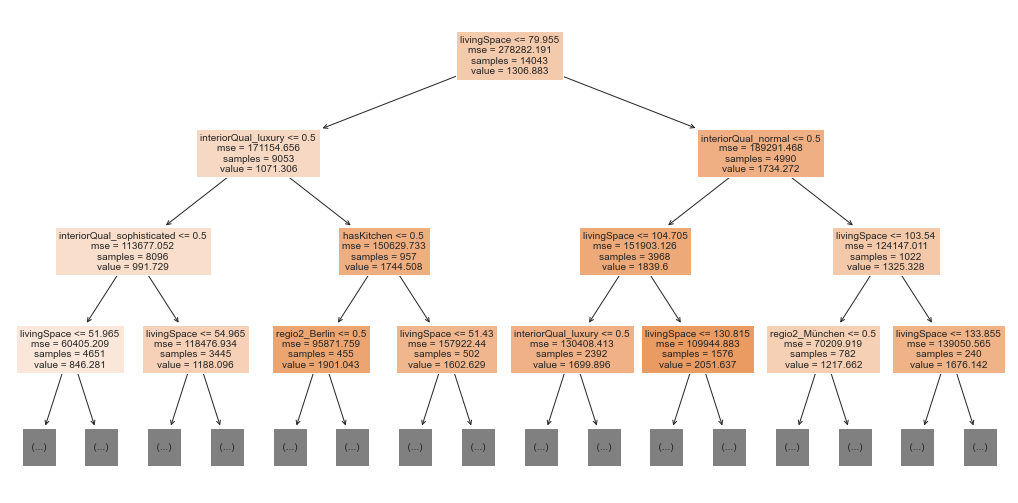

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18,9))
plot_tree(regressor_tunned, feature_names = FEATURES, max_depth=3, 
          class_names=TARGET, fontsize=10, filled = True);

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

Text(0, 0.5, 'Warmmiete')

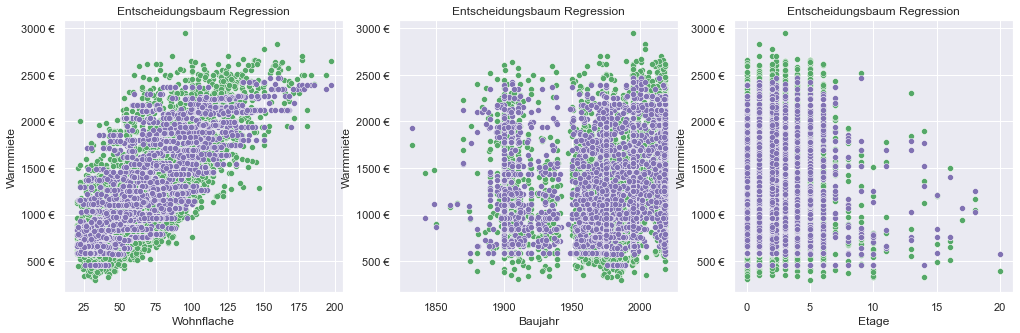

In [13]:
# Visualising the Decision Tree Regression Results 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17, 5))

sns.scatterplot(X_test['livingSpace'], y_test, color = 'g', ax=ax1)
sns.scatterplot(X_test['livingSpace'], y_pred_dt, color = 'm', ax=ax1)
ax1.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} €'.format(x)))
ax1.set_title('Entscheidungsbaum Regression')
ax1.set_xlabel('Wohnflache')
ax1.set_ylabel('Warmmiete')

sns.scatterplot(X_test['yearConstructed'], y_test, color = 'g', ax=ax2)
sns.scatterplot(X_test['yearConstructed'], y_pred_dt, color = 'm', ax=ax2)
ax2.set_title('Entscheidungsbaum Regression')
ax2.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} €'.format(x)))
ax2.set_xlabel('Baujahr')
ax2.set_ylabel('Warmmiete')

sns.scatterplot(X_test['floor'], y_test, color = 'g', ax=ax3)
sns.scatterplot(X_test['floor'], y_pred_dt, color = 'm', ax=ax3)
ax3.set_title('Entscheidungsbaum Regression')
ax3.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} €'.format(x)))
ax3.set_xlabel('Etage')
ax3.set_ylabel('Warmmiete')

Genauigkeit

In [14]:
# Cross fit training
#cross_val_scores = cross_val_score(regressor_tunned, X_train, y_train, cv=10)
#dt_train_score = cross_val_scores.mean()
#dt_test_score = regressor_tunned.score(X_test, y_test)

dt_train_score = regressor_tunned.score(X_train, y_train) 
dt_test_score = regressor_tunned.score(X_test, y_test)

print('Train score', toPercent(dt_train_score), 
      'Test score', toPercent(dt_test_score))

Train score 83.02% Test score 80.46%


RMSE

In [15]:
dt_mse = mean_squared_error(y_pred_dt, y_test)
dt_rmse = np.sqrt(dt_mse)
print("DecisionTree RMSE: {}".format(dt_rmse))

DecisionTree RMSE: 236.7995463479


MAE

In [16]:
dt_mae = mean_absolute_error(y_pred_dt, y_test)
print("Random Forest Regression MAE: {}".format(dt_mae))

Random Forest Regression MAE: 180.16891324287428


Wenn wir die Genauigkeit von MSE und MAE vor und nach der Optimierung vergleichen, zeigt sich eine Verbesserung.

Um das Gewicht der Merkmale zu verstehen, sortieren wir die Liste nach absteigender Wichtigkeit.

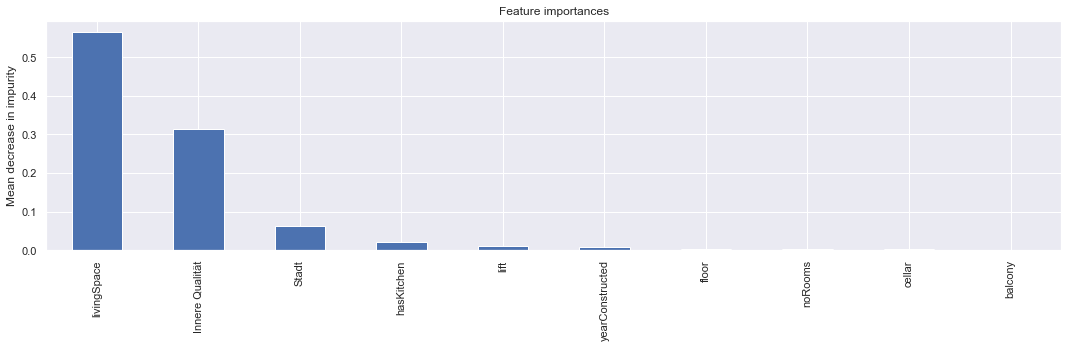

In [17]:
plotFeatureImportance(getFilteredImportances(regressor_tunned.feature_importances_))

Die Grafik zeigt, dass die 3 wichtigsten Merkmale **Wohnflache**, **Innere Qualität**, **Stadt** sind.

Zusammenfassend lässt sich sagen, dass die Genauigkeit des Entscheidungsbaums nicht ideal ist. Wir müssen weitere Methoden ausprobieren.

### KNeighborsRegressor

In [18]:
knn_params = {
    'n_neighbors': [5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'] 
}
model_knn = KNeighborsRegressor()
knn_gscv = GridSearchCV(model_knn, knn_params, cv=5, n_jobs=-1)
knn_gscv.fit(X_train, y_train)
knn_gscv.best_estimator_

KNeighborsRegressor(n_neighbors=7, weights='distance')

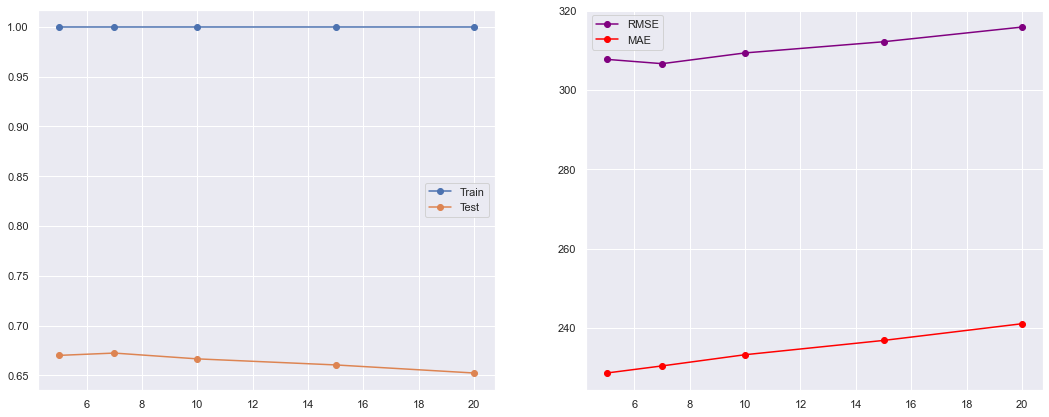

In [19]:
knn_best = knn_gscv.best_estimator_
knn_gscv_train = []
knn_gscv_test = []
knn_rmse_list = []
knn_mae_list = []
for neighbors in knn_params['n_neighbors']:
  tr = KNeighborsRegressor(n_neighbors=neighbors, 
                           weights=knn_best.weights).fit(X_train, y_train)
  preds = tr.predict(X_test)
  knn_gscv_train.append(tr.score(X_train, y_train))
  knn_gscv_test.append(tr.score(X_test, y_test))
  knn_rmse_list.append(np.sqrt(mean_squared_error(y_true=y_test, y_pred=preds)))
  knn_mae_list.append(mean_absolute_error(y_true=y_test, y_pred=preds))
  
plotAccuracyAndError(knn_params['n_neighbors'], knn_gscv_train, 
                     knn_gscv_test, knn_rmse_list, knn_mae_list)

Die schlechte Leistung amit den neuen Daten bedeutet wir haben Overfitting.

Genauigkeit

In [20]:
y_pred_knn = knn_gscv.predict(X_test)
knn_train_score = knn_gscv.score(X_train, y_train)
knn_test_score = knn_gscv.score(X_test, y_test)

print("KNeighbors Regression Accuracy: {}".format(toPercent(knn_test_score)))

KNeighbors Regression Accuracy: 67.24%


RMSE

In [21]:
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_rmse = np.sqrt(knn_mse)
print('KNeighbors RMSE: ', knn_rmse)

KNeighbors RMSE:  306.6327028004859


MAE

In [22]:
knn_mae = mean_absolute_error(y_test, y_pred_knn)
print('KNeighbors RMSE: ', knn_mae)


KNeighbors RMSE:  230.3986604047526


### Linear Regression

In [23]:
lin_regressor = LinearRegression()
lin_regressor.fit(X_train, y_train)

LinearRegression()

Genauigkeit

In [24]:
y_pred_lin = lin_regressor.predict(X_test)
lin_train_score = lin_regressor.score(X_train, y_train)
lin_test_score = lin_regressor.score(X_test, y_test)
print("Linear Regression Accuracy: {}".format(toPercent(lin_test_score)))

Linear Regression Accuracy: 78.92%


RMSE

In [25]:
lin_mse = mean_squared_error(y_pred_lin, y_test)
lin_rmse = np.sqrt(lin_mse)
print("Linear Regression RMSE: {}".format(lin_rmse))

Linear Regression RMSE: 245.92783470704168


MAE

In [26]:
lin_mae = mean_absolute_error(y_pred_lin, y_test)
print("Linear Regression MAE: {}".format(lin_mae))

Linear Regression MAE: 193.9153054381617


### SVR

In [27]:
params_svr =  {
    "kernel": ['rbf', 'linear', 'poly', 'sigmoid'], 
    "C": [1, 10]
    }
svr_regression = SVR()
svr_gscv = GridSearchCV(svr_regression, params_svr, cv=5, n_jobs=-1)
svr_gscv.fit(X_train, y_train)
pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', svr_gscv)])

pipe.fit(X_train, y_train)
y_pred_svr = pipe.predict(X_test)
svr_gscv.best_estimator_

SVR(C=10, kernel='linear')

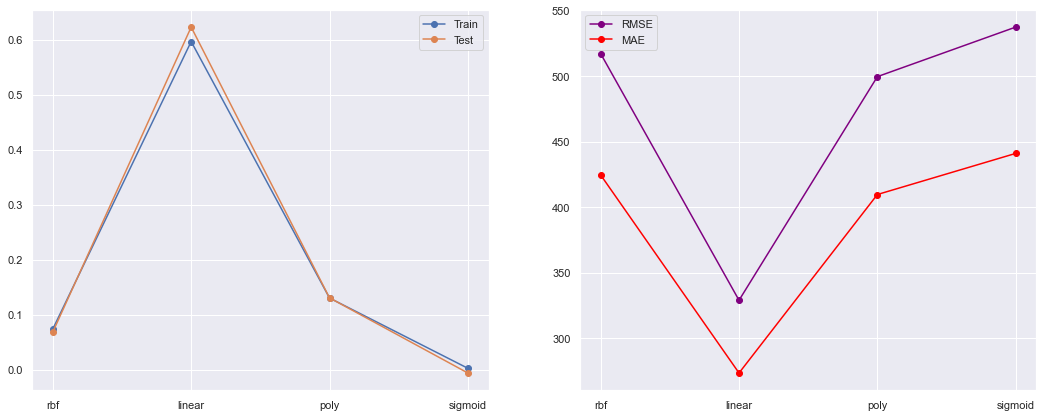

In [28]:
svr_best = svr_gscv.best_estimator_
svr_gscv_train = []
svr_gscv_test = []
svr_rmse_list = []
svr_mae_list = []
for kernel in params_svr['kernel']:
  tr = SVR(C=svr_best.C, kernel=kernel).fit(X_train, y_train)
  preds = tr.predict(X_test)
  svr_gscv_train.append(tr.score(X_train, y_train))
  svr_gscv_test.append(tr.score(X_test, y_test))
  svr_rmse_list.append(np.sqrt(mean_squared_error(y_true=y_test, y_pred=preds)))
  svr_mae_list.append(mean_absolute_error(y_true=y_test, y_pred=preds))
  
plotAccuracyAndError(params_svr['kernel'], svr_gscv_train, 
                     svr_gscv_test, svr_rmse_list, svr_mae_list)

Genauigkeit

In [29]:
svr_train_score = pipe.score(X_train, y_train)
svr_test_score = pipe.score(X_test, y_test)

print("SVR Accuracy: {}".format(toPercent(svr_test_score)))

SVR Accuracy: 78.57%


RMSE

In [30]:
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
print("SVR Regression RMSE: {}".format(svr_rmse))

SVR Regression RMSE: 247.99478076198127


MAE

In [31]:
svr_mae = mean_absolute_error(y_pred_svr, y_test)
print("SVR Regression MAE: {}".format(svr_mae))

SVR Regression MAE: 193.4893023479081


### Gradient Booster Regression

In [32]:
params = {
 'learning_rate': [0.1, 0.4, 0.5, 0.75],
 'n_estimators' : [100, 150, 200]
 }
gbr = GradientBoostingRegressor()
gbr_gscv = GridSearchCV(gbr, params, cv=5, return_train_score=True, 
                        n_jobs=-1).fit(X_train, y_train)
y_pred_gbr = gbr_gscv.predict(X_test)
gbr_gscv.best_estimator_

GradientBoostingRegressor(learning_rate=0.4, n_estimators=200)

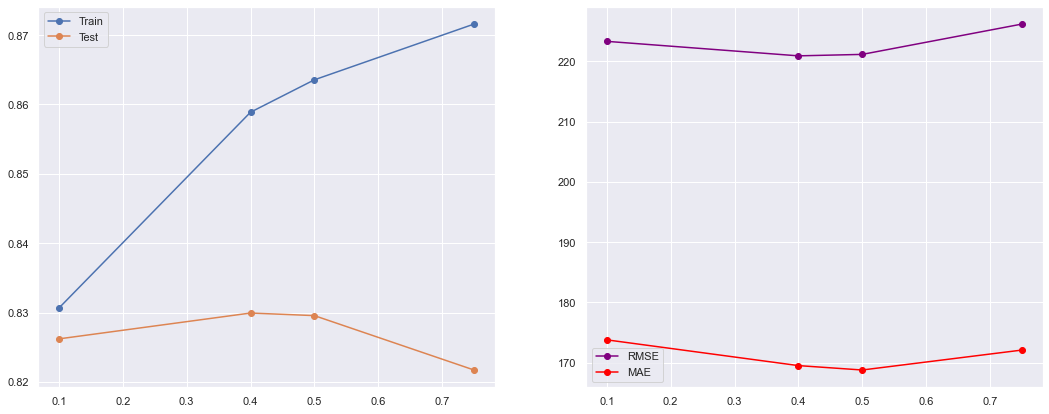

In [33]:
gbr_best = gbr_gscv.best_estimator_
gbr_gscv_train = []
gbr_gscv_test = []
gbr_rmse_list = []
gbr_mae_list = []
for lr in params['learning_rate']:
  tr = GradientBoostingRegressor(
      learning_rate=lr, 
      n_estimators=gbr_best.n_estimators).fit(X_train, y_train)
  preds = tr.predict(X_test)
  gbr_gscv_train.append(tr.score(X_train, y_train))
  gbr_gscv_test.append(tr.score(X_test, y_test))
  gbr_rmse_list.append(np.sqrt(mean_squared_error(y_true=y_test, 
                                                  y_pred=preds)))
  gbr_mae_list.append(mean_absolute_error(y_true=y_test, y_pred=preds))

plotAccuracyAndError(params['learning_rate'], gbr_gscv_train, 
                     gbr_gscv_test, gbr_rmse_list, gbr_mae_list)

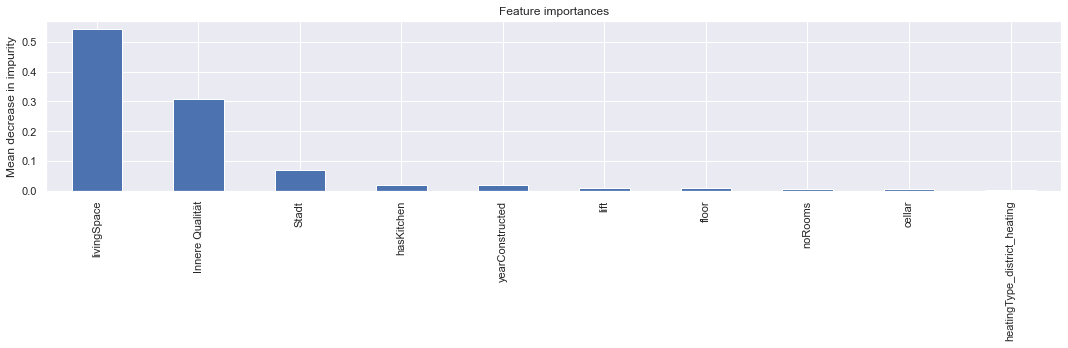

In [34]:
gbr_model = GradientBoostingRegressor(
    learning_rate=gbr_gscv.best_estimator_.learning_rate, 
     n_estimators=gbr_gscv.best_estimator_.n_estimators)
gbr_model.fit(X_train, y_train)
plotFeatureImportance(getFilteredImportances(gbr_model.feature_importances_))

Genauigkeit

In [35]:
gbr_train_score = gbr_gscv.score(X_train, y_train)
gbr_test_score = gbr_gscv.score(X_test, y_test)

print('Train score', toPercent(gbr_train_score), 
      'Test score', toPercent(gbr_test_score))

Train score 85.89% Test score 83.00%


RMSE

In [36]:
gbr_mse = mean_squared_error(y_true=y_test, y_pred=y_pred_gbr)
gbr_rmse = np.sqrt(gbr_mse)
print("Gradient Booster RMSE:", gbr_rmse)

Gradient Booster RMSE: 220.87384779550194


MAE

In [37]:
gbr_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_gbr)
print("Gradient Booster MAE: {}".format(gbr_mae))

Gradient Booster MAE: 169.50125141042423


# Evaluation

Die Evaluierung oder Evaluation sorgt für einen exakten Abgleich der erstellten Datenmodelle mit der Zielsetzung. Ziel ist es die am besten passende Modelle auszuwählen.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

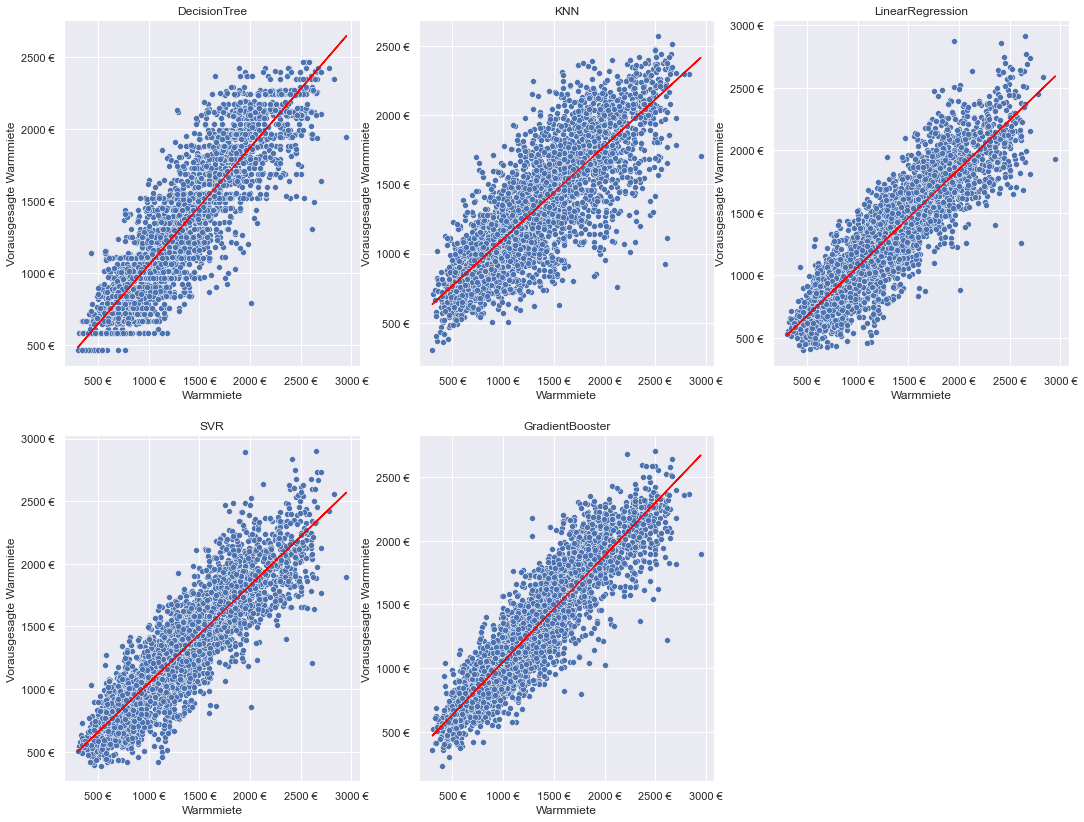

In [38]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 14) )
sns.set_theme(style="darkgrid")

# DecisionTree
addOverviewPlot('DecisionTree', ax1, y_pred_dt)

# KNN
addOverviewPlot('KNN', ax2, y_pred_knn)

# LinearRegression
addOverviewPlot('LinearRegression', ax3, y_pred_lin)

# SVR
addOverviewPlot('SVR', ax4, y_pred_svr)

# GradientBooster
addOverviewPlot('GradientBooster', ax5, y_pred_gbr)

ax6.set_axis_off()

In [39]:
data = {"Model": ["DecisionTree", "LinearRegression", 
                  "KNeighbors", "SVR", "GradientBooster"],
        "Testgenauigkeit": [toPercent(dt_test_score), toPercent(lin_test_score), 
                            toPercent(knn_test_score), toPercent(svr_test_score), 
                            toPercent(gbr_test_score)],           
        "Lerngenauigkeit": [toPercent(dt_train_score),  toPercent(lin_train_score), 
                            toPercent(knn_train_score), toPercent(svr_train_score), 
                            toPercent(gbr_train_score)],
        "RMSE": [dt_rmse, lin_rmse, knn_rmse, svr_rmse, gbr_rmse],
        "MAE": [dt_mae, lin_mae, knn_mae, svr_rmse, gbr_mae]}

results = pd.DataFrame(data=data)
results = results.T
results.columns = results.iloc[0]
results = results.drop(results.index[0])
results

Model,DecisionTree,LinearRegression,KNeighbors,SVR,GradientBooster
Testgenauigkeit,80.46%,78.92%,67.24%,78.57%,83.00%
Lerngenauigkeit,83.02%,77.47%,99.97%,77.23%,85.89%
RMSE,236.799546,245.927835,306.632703,247.994781,220.873848
MAE,180.168913,193.915305,230.39866,247.994781,169.501251


# Deployment

#### Warmmiete je Stadt

Kleinwohnung / Mittelgroße Wohnung / Große Wohnung

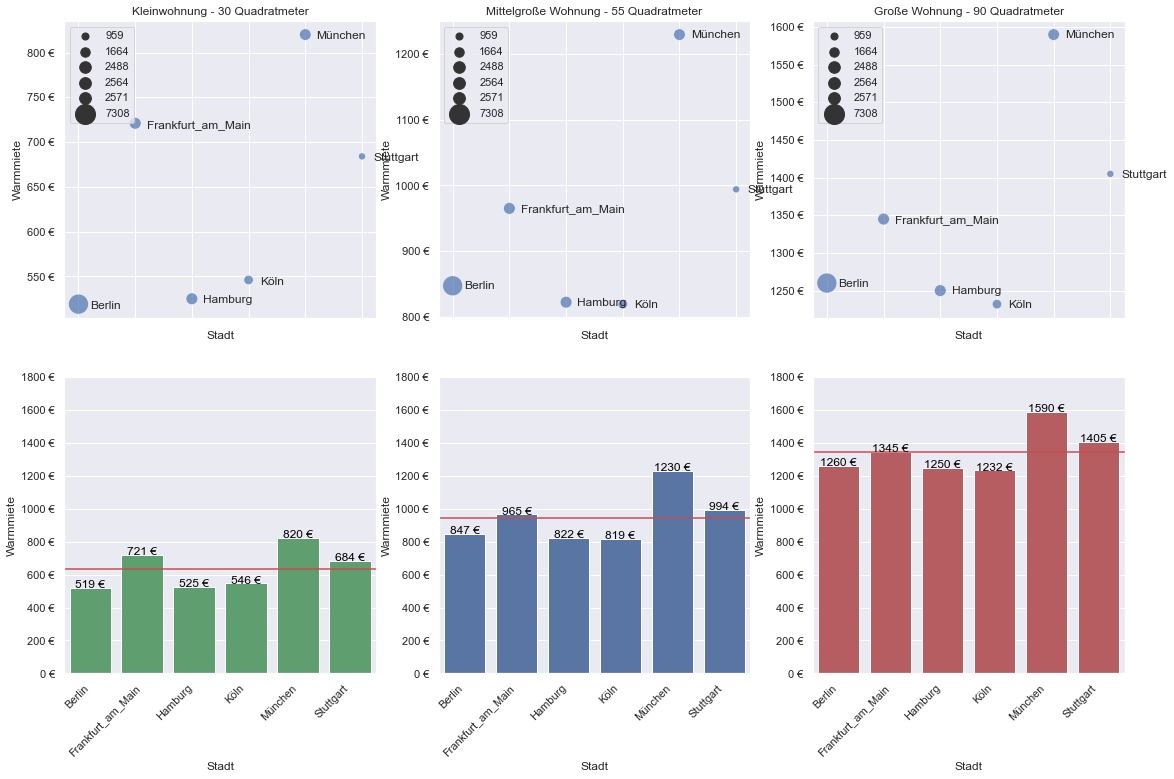

In [40]:
smSizeAp = getApartmentDf(livingSpace=30, noRooms=1)
smDf = generateXYData(gbr_model, smSizeAp)

mdSizeAp = getApartmentDf(livingSpace=55, noRooms=2)
mdDf = generateXYData(gbr_model, mdSizeAp)

lgSizeAp = getApartmentDf(livingSpace=90, noRooms=4)
lgDf = generateXYData(gbr_model, lgSizeAp)

plotCityPrice(
              dfs=[smDf, mdDf, lgDf], 
              titles=['Kleinwohnung - 30 Quadratmeter', 
                      'Mittelgroße Wohnung - 55 Quadratmeter', 
                      'Große Wohnung - 90 Quadratmeter'], 
              barColors=['g', 'b', 'r']
              )

#### Mietpreis pro Quadratmeter

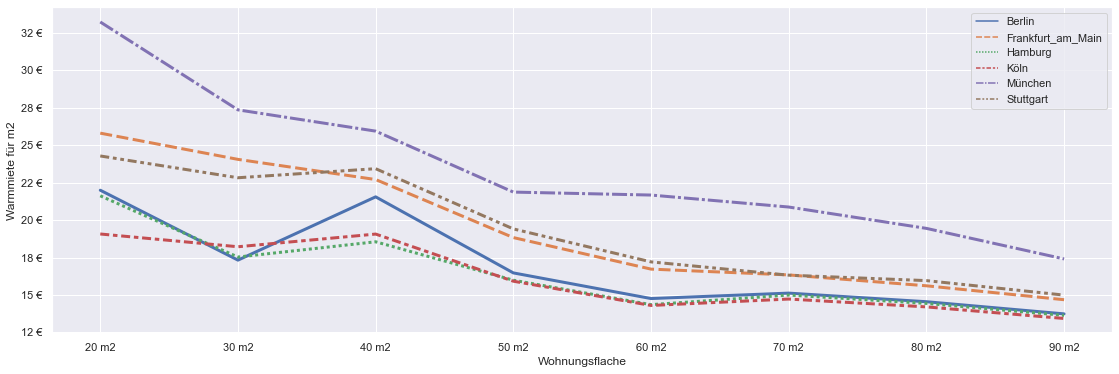

In [41]:
surface = pd.Series([20, 30, 40, 50, 60, 70, 80, 90])
rooms = pd.Series([1, 1, 2, 2, 2, 3, 3, 3])
csDf = pd.DataFrame({'surface': surface})
cities = getCities()

for city in cities:
  city_preds = []
  for j, surf in surface.iteritems():
    ap = getApartmentDf(livingSpace=surf, noRooms=rooms[j])
    ap.iloc[0]['regio2_'+city] = 1
    preds = gbr_model.predict(pd.concat([ap]))
    city_preds.append(preds[0]/surf)
  csDf[city] = city_preds
csDf.set_index(keys='surface', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.lineplot(data=csDf, linewidth=3, ax=ax)
ax.set_ylabel('Warmmiete für m2')
ax.set_xlabel('Wohnungsflache')
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} m2'.format(x)))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} €'.format(x)))



#### Mietpreisentwicklung 

Mittelgroße Wohnung(55 Quadratmeter)

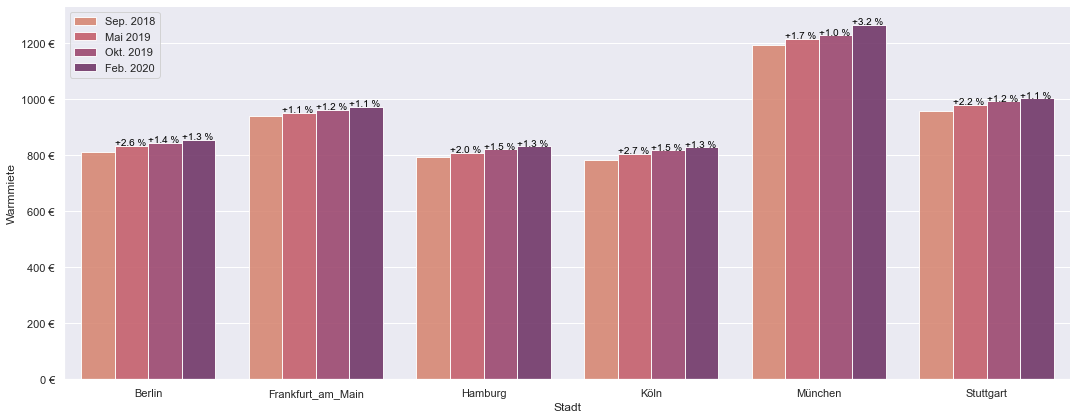

In [42]:
dateColumns = pd.Series(['date_Sep18', 'date_May19', 
                         'date_Oct19', 'date_Feb20'])
dateLabels = pd.Series(['Sep. 2018', 'Mai 2019', 
                        'Okt. 2019', 'Feb. 2020'])

cities = getCities()
dtDf = pd.DataFrame([], columns=['city', 'date', 'rent'])

for city in cities:
  for j, date in dateColumns.iteritems():
    ap = mdSizeAp.copy()
    ap.iloc[0]['regio2_'+city] = 1
    ap.iloc[0][date] = 1
    preds = gbr_model.predict(pd.concat([ap]))
    dtDf = dtDf.append({'city': city, 'date': dateLabels[j], 
                        'rent': preds[0]}, ignore_index=True)

dtsns = sns.catplot(data=dtDf, x='city', y='rent', hue='date', 
                    kind='bar', ci="sd", palette="flare", alpha=0.9, 
                    height=6, aspect=(15/6), legend=False)
dtsns.fig.get_axes()[0].legend(loc='upper left')
for ax in dtsns.axes.flat:
  ax.set_xlabel('Stadt')
  ax.set_ylabel('Warmmiete')
  ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, 
                                                 p: '{:.0f} €'.format(x)))
  label_catplot_percent(ax, cities, dateColumns.tolist())

#### Merkmal-Preis-Einfluss

Berlin - Mittelgroße Wohnung(55 Quadratmeter)

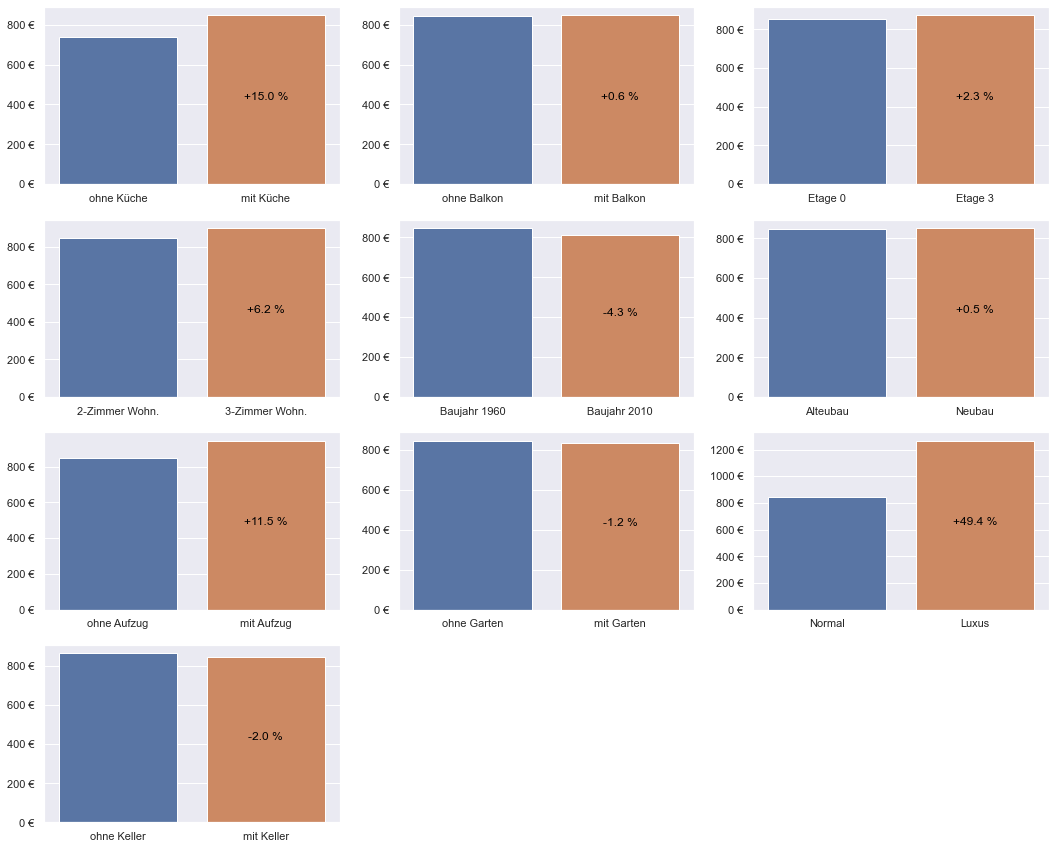

In [43]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), 
      (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(18, 15))
priceInfluence = [
     [ax1, [getApartmentDf(berlin=1, hasKitchen=0), getApartmentDf(berlin=1)], 
      ['ohne Küche', 'mit Küche']],
     [ax2, [getApartmentDf(berlin=1, balcony=0), getApartmentDf(berlin=1)], 
      ['ohne Balkon', 'mit Balkon']],
     [ax3, [getApartmentDf(berlin=1, floor=0), getApartmentDf(berlin=1, floor=3)], 
      ['Etage 0', 'Etage 3']],
     [ax4, [getApartmentDf(berlin=1), getApartmentDf(berlin=1, noRooms=3)], 
      ['2-Zimmer Wohn.', '3-Zimmer Wohn.']],
     [ax5, [getApartmentDf(berlin=1), getApartmentDf(berlin=1, yearConstructed=2010)], 
      ['Baujahr 1960', 'Baujahr 2010']],
     [ax6, [getApartmentDf(berlin=1), getApartmentDf(berlin=1, newlyConst=1)], 
      ['Alteubau', 'Neubau']],
     [ax7, [getApartmentDf(berlin=1), getApartmentDf(berlin=1, lift=1)], 
      ['ohne Aufzug', 'mit Aufzug']],
     [ax8, [getApartmentDf(berlin=1), getApartmentDf(berlin=1, garden=1)], 
      ['ohne Garten', 'mit Garten']],
     [ax9, [getApartmentDf(berlin=1, normal=1), getApartmentDf(berlin=1, luxury=1)], 
      ['Normal', 'Luxus']],
     [ax10, [getApartmentDf(berlin=1, cellar=0), getApartmentDf(berlin=1)], 
      ['ohne Keller', 'mit Keller']],
]
for a in priceInfluence:
  preds = gbr_model.predict(pd.concat(a[1]))
  df = pd.DataFrame({'preds': preds, 'labels': a[2]})
  sns.barplot(data=df, x='labels', y='preds', ax=a[0])
  a[0].yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:.0f} €'.format(x)))
  label_bar_percent(df['labels'], df['preds'], df['preds'], a[0])
  a[0].set_xlabel('')
  a[0].set_ylabel('')

ax11.set_axis_off()
ax12.set_axis_off()

**Erfolgskontrolle**

Nach dem Modeling mit fünf verschiedenen Methoden hat sich Gradient Booster Regression mit einer Testgenauigkeit von 82,89% als Methode mit dem besten Ergebnis herausgestellt. Zur Anwendung des Prognosemodells wurde sich aufgrund der Vielzahl an Städten im Datensatz (>400) auf die Großstädte Berlin, Hamburg, Frankfurt am Main, Köln, Stuttgart und München fokussiert. Die Ergebnisse sind in ihrer Genauigkeit aufgrund des Datensatzes und Zeitrahmens der Analyse bewusst eingegrenzt worden. 

Auf Grundlage des erarbeiteten Prognosemodells sind die folgenden Anwendungsergebnisse entstanden: 

* **Warmmiete je Stadt für kleine (30qm) / mittlere (55qm) / Große Wohnungen (90qm)**
* **Mietpreis pro qm je Stadt**
* **Mietpreisentwicklung je Stadt**
* **Merkmal-Preis Einfluss für mittelgroße Wohnungen in Berlin** 

Diese Anwendungsergebnisse können zur Beantwortung der Zielsetzung genutzt werden. 

1. Zielsetzung: Es soll eine Schätzung entstehen, wie viel Mietkosten eine Person für eine Wohnung mit bestimmten Merkmalen zahlen muss. 
* Durch die Anwendung "Merkmal-Preis Einfluss" sind einer interessierten Person die Merkmale, die die Warmmiete treiben übersichtlich dargestellt. Sollte man z.B. darauf achten, möglichst wenig Warmmiete zu zahlen, könnte man sich nach Betrachtung dieser Anwendung für eine Wohnung ohne Lift entscheiden. 
2. Zielsetzung: Ist ein bei Immmobilienscout24 gefundenes Angebot günstig, normalpreisig oder teuer?
* Durch die Anwendung "Warmmiete je Stadt" kann eine interessierte Person ein gefundenes Angebot leicht mit den erhobenen Daten abgleichen. Hierbei kann sie das gefundene Angebot mit der durchschnittlichen Warmmiete der spezifischen Stadt oder dem Durchschnitt der betrachteten Städte vergleichen. Somit wird ein Indikator zur Hilfestellung bei der Wohnungssuche geschaffen, der einfach anwendbar ist. Die Kategorisierung der Wohnungsgröße (klein / mittel / groß) erleichtert das Nutzen dieses Indikators. 


**Weitere Erkenntnisse**

In der Anwendung "Mietpreisentwicklung je Stadt" ist ein genereller Anstieg der Warmmieten zu erkennen. Grundlage hierzu können verschieden Faktoren sein. Als da wären z.B. die allgemein steigende Inflation oder der Trend der Landflucht in Großstädte in Verbindung mit Arbeitsplätzen.

Weitere Erkenntnisse aus der Anwendung "Mietpreis pro qm je Stadt" sind, dass die Preise pro qm mit steigender Wohnungsgröße sinken. 

Durch die Kombination der entstandenen Anwendungen kann von einer erhöhten Transparenz bei der Suche nach Mietwohnungen ausgegangen werden. 

**Fazit**

Das erarbeitete Prognosemodell zur Ermittlung von Warmmieten und deren Einflussfaktoren kann mit den zur Verfügung stehenden Daten eine gut Hilfestellung bei der Suche nach Wohnungen bieten. Die Genauigkeit der Regression beträgt ~83%. Daraus kann geschlussfolgert werden, dass die Erhobenen Daten auch in der Realität Anwendung finden können. 

# Quellen

**Machine Learning Mastery**<br>
A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning<br>
https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

Save and Load Machine Learning Models in Python with scikit-learn<br>
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

How to Identify Overfitting Machine Learning Models in Scikit-Learn<br>
https://machinelearningmastery.com/overfitting-machine-learning-models/

How to Avoid Overfitting in Deep Learning Neural Networks<br>
https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/

Overfitting and Underfitting With Machine Learning Algorithms<br>
https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/

How to use Learning Curves to Diagnose Machine Learning Model Performance<br>
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

How to Calculate the Bias-Variance Trade-off with Python<br>
https://machinelearningmastery.com/calculate-the-bias-variance-trade-off/

How to Calculate Feature Importance With Python<br>
https://machinelearningmastery.com/calculate-feature-importance-with-python/

Ordinal and One-Hot Encodings for Categorical Data<br>
https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

How to One Hot Encode Sequence Data in Python<br>
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
<br><br>
**Toward Data Science**

RMSE & MAE<br>
https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383#:~:text=Technically%2C%20RMSE%20is%20the%20Root,actual%20values%20of%20a%20variable.

Preprocessing with sklearn: a complete and comprehensive guide<br>
https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

Add Text Labels to Scatterplot<br>
https://towardsdatascience.com/how-to-add-text-labels-to-scatterplot-in-matplotlib-seaborn-ec5df6afed7a

Visualizing Decision Trees<br>
https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

Responsible Machine Learning with Error Analysis<br>
https://towardsdatascience.com/responsible-machine-learning-with-error-analysis-a7553f649915

An Introduction to Support Vector Regression<br>
https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2

Your Guide to Linear Regression Models<br>
https://towardsdatascience.com/your-guide-to-linear-regression-models-df1d847185db

How to tune a Decision Tree<br>
https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

3 Techniques to Avoid Overfitting of Decision Trees<br>
https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09#:~:text=Pruning%20refers%20to%20a%20technique,%2Dpruning%20and%20Post%2Dpruning.

Almost Everything You Need To Know About Decision Trees<br>
https://towardsdatascience.com/almost-everything-you-need-to-know-about-decision-trees-with-code-dc026172a284

The Mathematics of Decision Trees, Random Forest and Feature Importance in Scikit-learn and Spark<br>
https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

What and why behind fit_transform() and transform() in scikit-learn<br>
https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

Get Started: 3 Ways to Load CSV files into Colab<br>
https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

5 Ways to Apply Data Science to Real Estate<br>
https://towardsdatascience.com/5-ways-to-apply-data-science-to-real-estate-e18cdcd0c1a6
<br><br>
**Springboard**

Decision tree implementation<br>
https://www.springboard.com/blog/data-science/decision-tree-implementation-in-python/
<br><br>
**Kaggle**<br>
Apartment rental offers in Germany<br>
https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany

An interecative data science tutorial<br>
https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial
<br><br>
**Github**<br>
Santiago Basulto - Data Science Course<br>
https://github.com/ine-rmotr-curriculum/data-cleaning-rmotr-freecodecamp

Gradient Boosting Regressor example<br>
https://opendatagroup.github.io/Knowledge%20Center/Tutorials/Gradient%20Boosting%20Regressor/

Rental price prediction<br>
https://github.com/kumaranurag7/Rental-price-prediction

CraigList housing rent predictions<br> 
https://github.com/scrapfishies/CL-housing-rent-predictions

NYC rent predictions<br>
https://github.com/moorissa/nycrentpredictor

Predicting rental price Morocco<br>
https://github.com/MOUHASSINE-badreddine/Predicting_rental_price_Morocco/blob/main/Predicting%20apartment%20rental%20price%20in%20Morocco.ipynb

NYC Airbnb listing prices<br>
https://github.com/veraguzelsoy/airbnb_NYC/blob/master/NYC_AirBNB_Listing_Prices.ipynb

Statistical data analysis Dublin rental properties<br>
https://github.com/colin-hehir/Statistical-Data-Analysis-Machine-Learning-Dublin-Rental-Properties

Rental price prediction Malaysia<br>
https://github.com/limchiahooi/predict-rental-prices

Measure of Bias and Variance – An Experiment<br>
https://github.com/sayanam/MachineLearning/blob/master/ExperimentationWithBiasAndVariance/BiasAndVariance_V2.ipynb
<br><br>
**Pandas**<br>
https://pandas.pydata.org/docs/user_guide/10min.html#min
<br><br>
**Numpy**<br>
https://numpy.org/doc/stable/user/quickstart.html
<br><br>
**Seaborn**<br>
https://seaborn.pydata.org/tutorial.html
<br><br>
**Scikit Learn**

Decision Tree<br>
https://scikit-learn.org/stable/modules/tree.html

Linear Regression<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

KNeighborsRegressor<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

SVR<br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR

Gradient Booster Regression<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

Parameter Tuning<br>
https://scikit-learn.org/stable/modules/grid_search.html

Cross-Validation<br>
https://scikit-learn.org/stable/modules/cross_validation.html
